Time per sample/timestep: 0.0167
Samples per second: 60.00
Counts per timestep (sample): 1
Total Samples/Timesteps: 28000
Total time of Data Collection: 466.6333333333333 s


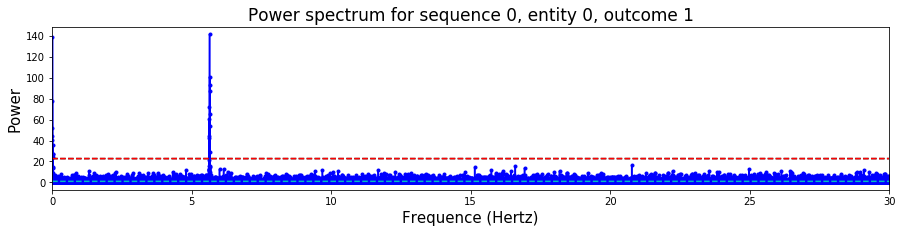

#1 Frequency: 5.6400 Hz
#2 Frequency: 0.0096 Hz
#3 Frequency: 5.6443 Hz
#4 Frequency: 5.6432 Hz
#5 Frequency: 5.6379 Hz
Highest frequency tested is 29.999 Hz


In [7]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data
from helpers import *
from drift_file_io import drift_input, calculate_average_timestep, merge_lines
import NoiseSignal2 as ns
savepath = None

save = False
data_option = 3
###############file io (option 2) is for each line being one sample, merge (opt. 3) is to combine all lines into one sample
###########################################Manipulate variables here ###############################################
#################################################################################################################
#For reading in experimental data: enter here
if data_option == 2 or data_option == 3:
    base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/PrelimData/" 
    name = '2018_08_20/2018_08_20_1041_51_DRIFT' #specify date_folder/txt_file_name
    file_loc = base + name + ".txt"
    time_per_sample = 1/60 #seconds, only necessary if you're doing the merge lines
    savepath = None
    if save and (data_option == 2 or data_option == 3):
        savepath = base  + name + "_Merged_Bitstring_Plot.png"
##################################################################################################################
##############################################################################################################
#Don't change anything below this line for regular program operation

if data_option == 2:
    raw_bit_array, ones_count_array, zeros_count_array, timestamp_array = drift_input(file_loc)
    time_per_sample = calculate_average_timestep(timestamp_array)
    print("Data is loaded...Beginning Drift Analysis")
elif data_option == 3:
    ones_count_array, zeros_count_array, timestamp_array = merge_lines(file_loc, time_per_sample)
    
#calculate results and print relevant information
print("Time per sample/timestep: {:.4f}".format(time_per_sample))
print("Samples per second: {:.2f}".format(1/time_per_sample))
nCounts = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
print("Counts per timestep (sample): {}".format(nCounts))
nSamples = len(ones_count_array)
print("Total Samples/Timesteps: {}".format(nSamples))
print("Total time of Data Collection: {} s".format(timestamp_array[len(timestamp_array) - 1] - timestamp_array[0]))
drifted = drift.do_basic_drift_characterization(ones_count_array, counts=nCounts, timestep=time_per_sample,timestamps=timestamp_array, verbosity=0)
drifted.plot_power_spectrum(sequence=0, entity=0, outcome=1, savepath=savepath)

#analyze the frequency-power spectrum
frequencies = list(drifted.frequencies)
power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
sorted_groups = create_sorted_tuples(frequencies, power_spectrum)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))
#print("Spacing is {:.4f} Hz".format(frequencies[1]-frequencies[0]))
print("Highest frequency tested is {:.3f} Hz".format(frequencies[len(frequencies) - 1]))

if save:
    with open(base + name + "_Merged_Bitstring_Top_Freqs.txt","w") as out:
        out.write("Time per sample/timestep: {:.4f}\n".format(time_per_sample))
        out.write("Samples per second: {:.2f}\n\n".format(1/time_per_sample))
        for i in range(num_points):
            out.write("#{} Frequency: {:.3f} Hz\n".format(i+1, sorted_groups[i][0]))
            
    with open(base + name + "_Merged_Bitstring_All_Output.txt","w") as out:
        out.write("Frequency(Hz)\tPower(a.u.)\n")
        for i in range(len(frequencies)):
            out.write("{}\t{}\n".format(frequencies[i], power_spectrum[i]))

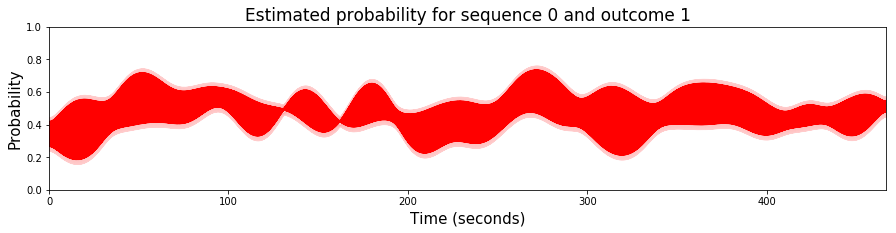

Max power is 141.78 at a frequency of 5.6400 Hz
Frequencies going into IDCT:
[5.64]


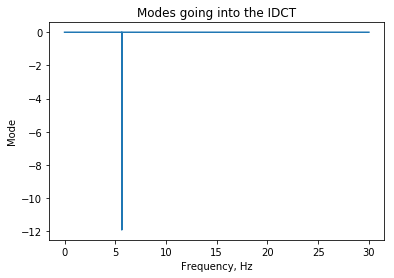

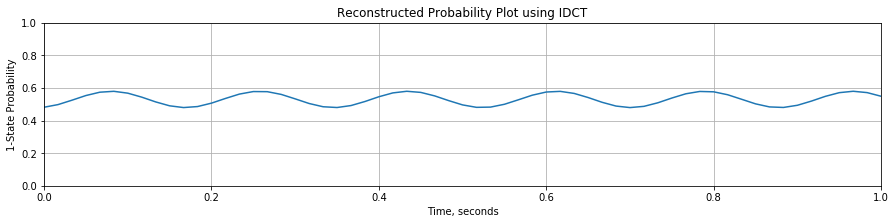

In [2]:
######### Trying to extract more information out of the pyGSTi IDCT

#here is the reconstructed P(t) function that it generates based off the input
drifted.plot_estimated_probability(0,0,1)

##### try to generate the above plot on my own
#copy all relevant output from the drift object
all_frequencies = list(drifted.frequencies)
significant_frequencies = drifted.pspepo_drift_frequencies[0,0,1]
significant_indices = [0]*len(significant_frequencies)
#finds the indices of the significant frequencies out the entire frequency list
for i in range(len(significant_frequencies)):
    sig_freq = significant_frequencies[i]
    sig_index = all_frequencies.index(sig_freq)
    significant_indices[i] = sig_index
#make the mode zero if it's not above the significance threshold
all_modes = drifted.pspepo_modes[0,0,1,:]
significant_modes = all_modes
significant_modes[drifted.pspepo_power_spectrum[0,0,1,:] < drifted.pspepo_significance_threshold] = 0
the_null_hypothesis = np.mean(ones_count_array)*np.ones(nSamples,float)/nCounts

#now select only the frequencies and modes of interest to go into the IDCT
lower_freq = 5.5
higher_freq = 5.7
#find the max power within the specified range
powers = list(all_modes**2)
max_power = find_max_power(all_frequencies, powers, lower_freq, higher_freq)
max_power_index = powers.index(max_power)
max_frequency = all_frequencies[max_power_index]
print("Max power is {:.2f} at a frequency of {:.4f} Hz".format(max_power, max_frequency))
#create an empy list for the frequencies of interest, and one for all the modes, where all those below significance are 0
modified_frequencies = []
modified_modes = [0]*len(all_modes)
#for each significant index corresponding to a significant frequency, make the associated power zero if the frequency
# isn't within the desired low and high bounds
for sig_index in significant_indices:
    if lower_freq < all_frequencies[sig_index] < higher_freq:
        modified_frequencies.append(all_frequencies[sig_index])
        modified_modes[sig_index] = all_modes[sig_index]
        continue
    else:
        modified_modes[sig_index] = 0  
        
#this line will screw up everything above this, and plot only the modes and frequencies of interest 
selected_indices = [max_power_index] #right now, it's only taking in the max power from the band specified above
modified_frequencies = []
modified_modes = [0]*len(all_modes)
for i in range(len(all_modes)):
    if i in selected_indices:
        modified_frequencies.append(all_frequencies[i])
        modified_modes[i] = all_modes[i]

#plot the modified power spectrum going into the IDCT
print("Frequencies going into IDCT:")
print(modified_frequencies)
plt.plot(all_frequencies, modified_modes)
plt.xlabel("Frequency, Hz")
plt.ylabel("Mode")
plt.title("Modes going into the IDCT")
plt.show()


#do the reconstruction via IDCT here
my_reconstruction = drift.IDCT(modified_modes, null_hypothesis=the_null_hypothesis, counts=nCounts)/nCounts
my_reconstruction = drift.renormalizer(my_reconstruction, method='logistic')


#plot the reconstruction versus time
plt.figure(figsize=(15,3))
plt.title("Reconstructed Probability Plot using IDCT")
plt.ylabel("1-State Probability")
plt.xlabel("Time, seconds")
plt.ylim(0,1)
times = np.linspace(0, time_per_sample*nSamples, nSamples)
plt.grid()
plt.xlim(0, 1)#times[-1])
plt.plot(times, my_reconstruction)
plt.show()

IndexError: list index out of range

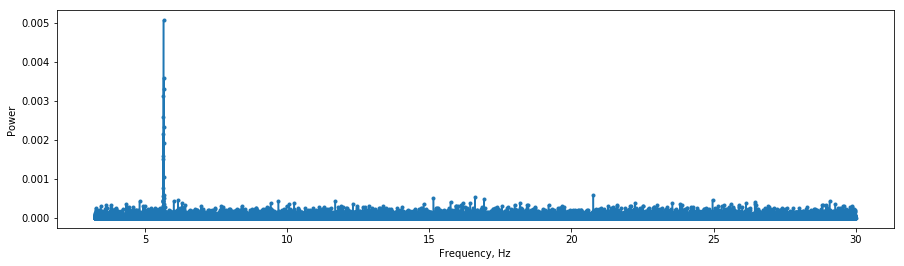

In [3]:
###################This cell is for truncating data and only seeing certain frequencies
mindex =3000
maxdex = 150000#len(frequencies)-1


fig = plt.figure(figsize=(15,4))
plt.plot(frequencies[mindex:maxdex], np.asarray(power_spectrum[mindex:maxdex])/nSamples,ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((frequencies[mindex], frequencies[maxdex]))
plt.title("TRUNCATED & NORMALIZED Merged-Line Power Spectrum with Indices {} to {}".format(mindex, maxdex))
plt.show()

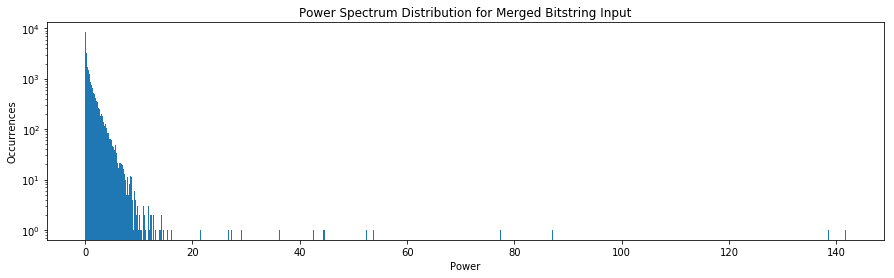

Total power of spectrum is 28000.000
There were 28000 data points


In [4]:
############look at distribution of powers
plt.figure(figsize=(15,4))
plt.hist(power_spectrum, bins = 1000, log=True)
plt.title("Power Spectrum Distribution for Merged Bitstring Input")
plt.xlabel("Power")
plt.ylabel("Occurrences")
plt.show()

############### looking at the total power of the spectrum
total_power = np.sum(power_spectrum)
nSamples = len(ones_count_array)
print("Total power of spectrum is {:.3f}".format(total_power))
print("There were {} data points".format(nSamples))

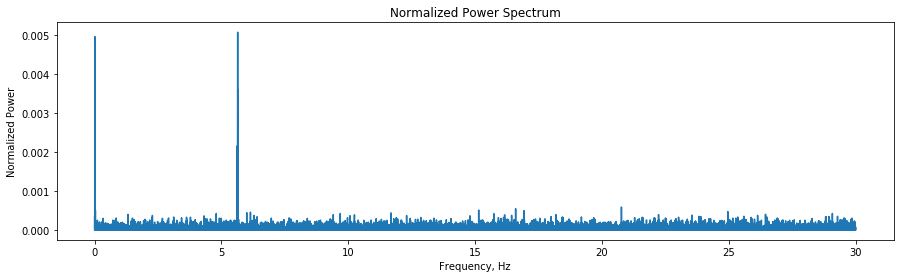

Freq: 5.640 Hz,	Norm. Power: 5.1e-03
Freq: 0.010 Hz,	Norm. Power: 5.0e-03


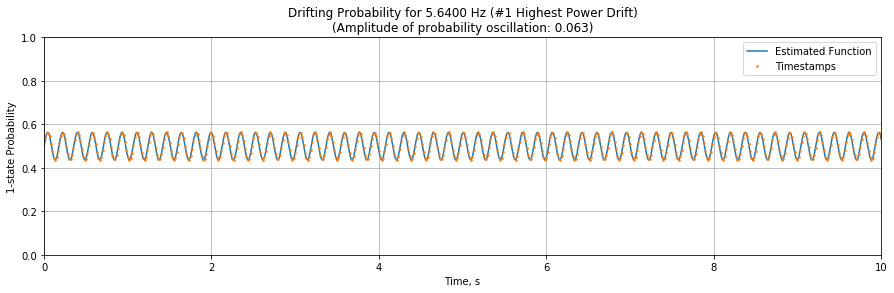

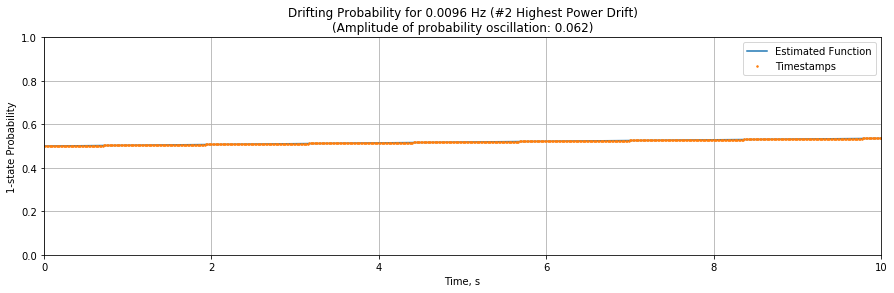

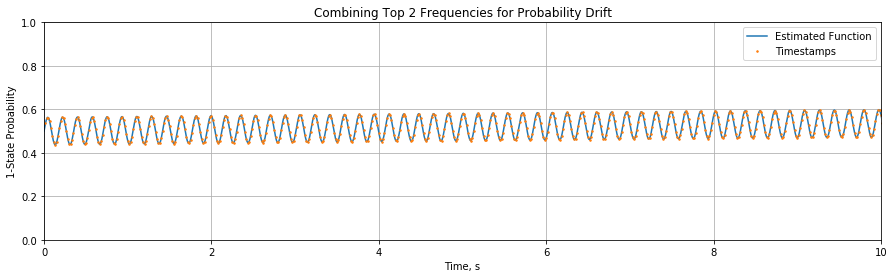

In [5]:
############# Display normalized spectrum
normalized_power_spectrum = np.asarray(power_spectrum)/nSamples
plt.figure(figsize=(15,4))
plt.plot(frequencies, normalized_power_spectrum)
plt.title("Normalized Power Spectrum")
plt.xlabel("Frequency, Hz")
plt.ylabel("Normalized Power")
plt.show()

# Option 1: take the top *amount* powers found earlier, normalize them, and find their amplitudes
# Option 2: only look at the top power within a specified range of frequencies
frequencies_option = 1
freq_range=(1.15, 1.25)

if frequencies_option==1:
    amount = 2
    top_tups = sorted_groups[:amount]
    top_freqs = [top_tups[i][0] for i in range(amount)]
    top_norm_powers = [top_tups[i][1]/nSamples for i in range(amount)]
    output = [print("Freq: {:.3f} Hz,\tNorm. Power: {:.1e}".format(top_freqs[i], top_norm_powers[i])) for i in range(amount)]
elif frequencies_option==2:
    amount = 1
    top_tups = create_sorted_tuples(frequencies, power_spectrum, x_limits=freq_range)
    top_freqs = [top_tups[i][0] for i in range(amount)]
    top_norm_powers = [top_tups[i][1]/nSamples for i in range(amount)]
    output = [print("Freq: {:.3f} Hz,\tNorm. Power: {:.1e}".format(top_freqs[i], top_norm_powers[i])) for i in range(amount)]

###using a manual fit I calibrated with simulated data
def manual_exp_power_to_prob(x, a, b, c):
        return (1/b)*np.log((x - c)/a)
a = 0.0010
b=5.72
c=-0.02
## >>> If you want to calculate a prob based on a power, just for fun, do it below and uncomment the print line.
#power_val = 0.005
#print("1-prob due to power of {} is: {:.3f}".format(power_val, manual_exp_power_to_prob(power_val, a,b,c)))


##### calculate and plot maximum 1-state probabilities from each of the frequencies
def sine(t, max_prob, freq, phase):
    return (max_prob-0.5)*np.sin(2*np.pi*freq*t + phase)+0.5
    
top_probs = [manual_exp_power_to_prob(power, a,b,c) for power in top_norm_powers]
end_time = timestamp_array[-1]
continuous_time = np.arange(0, end_time, time_per_sample/2)
display_time = 10
phases=[0]*amount
for i in range(amount):
    plt.figure(figsize=(15,4))
    plt.plot(continuous_time, sine(continuous_time, top_probs[i], top_freqs[i], phases[i]), label='Estimated Function')
    plt.plot(timestamp_array, sine(timestamp_array, top_probs[i], top_freqs[i], phases[i]), marker='.', markersize=3, ls='None',label="Timestamps")
    plt.ylim(0,1)
    plt.xlim(0,display_time)
    plt.grid()
    plt.legend()
    plt.xlabel("Time, s")
    plt.ylabel("1-state Probability")
    plt.title("Drifting Probability for {:.4f} Hz (#{} Highest Power Drift)\n(Amplitude of probability oscillation: {:.3f})".
              format(top_freqs[i], i+1, top_probs[i] - 0.5))
    plt.show()
    
#### define and plot a function that combines the top frequencies
def combined_sine(t, probs, freqs, phases):
    prob = 0.5
    for i in range(amount):
        phase = 0
        prob += (sine(t, probs[i], freqs[i], phases[i]) - 0.5)
    return prob

plt.figure(figsize=(15,4))
plt.title("Combining Top {} Frequencies for Probability Drift".format(amount))
plt.xlabel("Time, s")
plt.ylabel("1-State Probability")
plt.plot(continuous_time, combined_sine(continuous_time, top_probs, top_freqs, phases), label="Estimated Function")
plt.plot(timestamp_array, combined_sine(timestamp_array, top_probs, top_freqs, phases), label="Timestamps",ls='None',marker='.',markersize=3)
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.xlim(0,display_time)
plt.show()



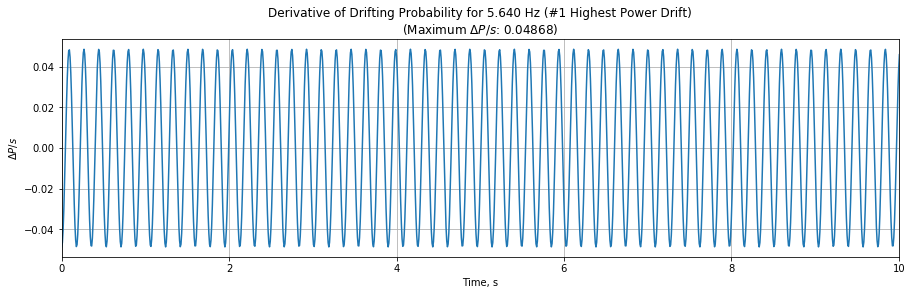

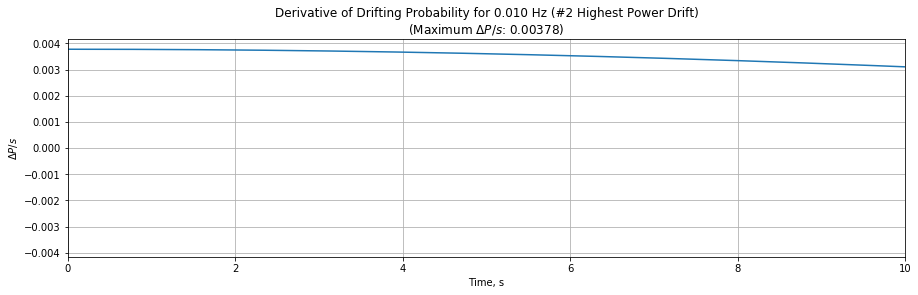

'\nplt.figure(figsize=(15,4))\nplt.plot(continuous_time, d(s_all, continuous_time))\nplt.xlim(0,display_time)\nplt.grid()\nplt.xlabel("Time, s")\nplt.ylabel("$\\Delta P/s$")\nplt.title("Derivative of Drifting Probability")\nplt.show()'

In [6]:
###### Calculate and plot first derivative for each drift component and the combined function.
#### This should correspond to change in probability per unit time.

display_time = 10 #total seconds you want to show; must be lower than greatest timestamp

#make functions for each frequency of i0000000000000000000000000000000nterest and the combined one where the only variable is time
#assumes that the 'amount' variable is <= 2. If geater, just add more of the s# functions.
import scipy.misc
from scipy.misc import derivative as d
def s_all(t):
    return combined_sine(t, top_probs, top_freqs, phases)
def s0(t):
    return sine(t, top_probs[0], top_freqs[0], phases[0])
def s1(t):
    if amount < 1: return None
    return sine(t, top_probs[1], top_freqs[1], phases[1])
def s2(t):
    if amount < 2: return None
    return sine(t, top_probs[2], top_freqs[2], phases[2])
funcs = [s0, s1, s2]

for i in range(amount):
    plt.figure(figsize=(15,4))
    delta_p = d(funcs[i], continuous_time)
    plt.plot(continuous_time, delta_p)
    max_delta_p = np.amax(delta_p)
    plt.xlim(0,display_time)
    plt.grid()
    plt.xlabel("Time, s")
    plt.ylabel("$\Delta P/s$")
    plt.title("Derivative of Drifting Probability for {:.3f} Hz (#{} Highest Power Drift)\n(Maximum $\Delta P/s$: {:.5f})".
              format(top_freqs[i], i+1, max_delta_p))
    plt.show()

'''
plt.figure(figsize=(15,4))
plt.plot(continuous_time, d(s_all, continuous_time))
plt.xlim(0,display_time)
plt.grid()
plt.xlabel("Time, s")
plt.ylabel("$\Delta P/s$")
plt.title("Derivative of Drifting Probability")
plt.show()'''